In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from time import time
register_matplotlib_converters()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


# Ice Cream Production Data

In [2]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [4]:
# Read Data
production_ice_cream = pd.read_csv('ice_cream.csv',parse_dates=[0],index_col=0,squeeze=True,date_parser=parser)

In [5]:
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: IPN31152N, Length: 577, dtype: float64

In [6]:
production_ice_cream.rename('production',inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [9]:
#Infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [10]:
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [11]:
## Get data form 2010
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

In [12]:
production_ice_cream

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 121, dtype: float64

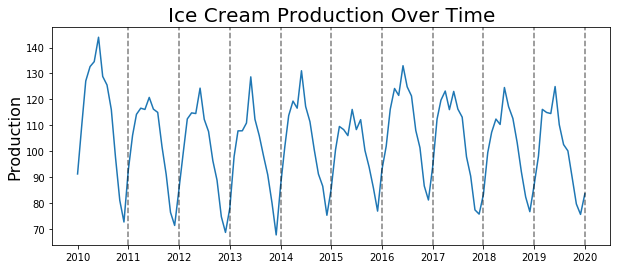

In [16]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title("Ice Cream Production Over Time",fontsize=20)
plt.ylabel("Production",fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

## ACF Plot

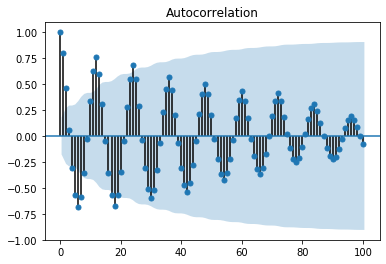

In [19]:
acf_plot = plot_acf(production_ice_cream,lags=100)

* Based on decaying ACF, we are likely dealing with an Auto Regressive Process

## PACF Plot

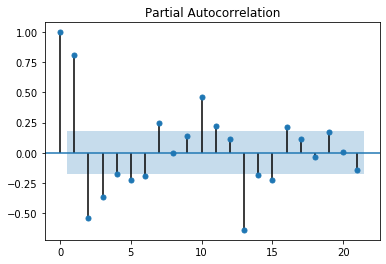

In [20]:
pacf_plot = plot_pacf(production_ice_cream)

* Based on PACF, we should start with an Auto Regressive model with lags 1,2,3

# Get Training and Test Sets

In [75]:
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

In [76]:
train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end+timedelta(days=1):test_end]

# AR Model

In [77]:
# Create Model
model = ARMA(train_data,order=(7,0))

In [78]:
# Fit model
start_time = time()
model_fit = model.fit()
end_time = time()
print("Model fitting Time:",end_time-start_time)

Model fitting Time: 2.2129404544830322


In [79]:
## Summary of model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(7, 0)   Log Likelihood                -361.526
Method:                       css-mle   S.D. of innovations              6.754
Date:                Thu, 10 Dec 2020   AIC                            741.051
Time:                        21:23:32   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.6216      1.159     89.389      0.000     101.350     105.894
ar.L1.production     0.9497      0.092     10.267      0.000       0.768       1.131
ar.L2.production    -0.0964 

In [80]:
# Get Prediction Start Date and End Date
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [81]:
# Predicitons
predicitons = model_fit.predict(start=pred_start_date,end=pred_end_date)

In [82]:
residuals = test_data - predicitons

### Plotting Residuals

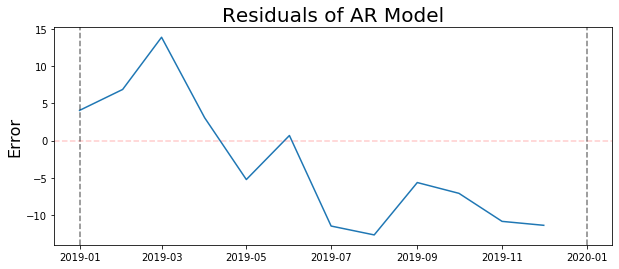

In [83]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals of AR Model",fontsize=20)
plt.ylabel("Error",fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

### Plotting Predictions vs Actuals

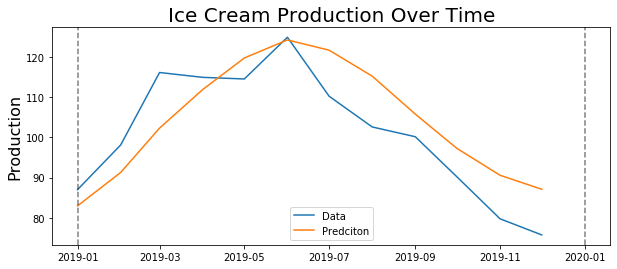

In [84]:
plt.figure(figsize=(10,4))
plt.plot(test_data,label='Data')
plt.plot(predicitons,label = 'Predciton')
plt.title("Ice Cream Production Over Time",fontsize=20)
plt.ylabel("Production",fontsize=16)
plt.legend()
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

In [85]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0802


In [86]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 8.725150186967285
